<a href="https://colab.research.google.com/github/anmorgul/ml20192/blob/master/get_eyes2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import urllib.request
import csv
import cv2
import dlib
import fnmatch
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!git clone https://github.com/SilvesterHsu/ORLFaceRecognition-PCA.git


Cloning into 'ORLFaceRecognition-PCA'...
remote: Enumerating objects: 604, done.
remote: Total 604 (delta 0), reused 0 (delta 0), pack-reused 604
Receiving objects: 100% (604/604), 3.59 MiB | 26.66 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [0]:
detector = dlib.get_frontal_face_detector()
urllib.request.urlretrieve('https://github.com/AKSHAYUBHAT/TensorFace/raw/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat', 'shape_predictor_68_face_landmarks.dat')
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [0]:
def geteye(landmarks, eye):
   return landmarks.part(eye).x, landmarks.part(eye).y

def geteyes(landmarks, r, l):
  return geteye(landmarks, l), geteye(landmarks, r)
  #return landmarks.part(l).x, landmarks.part(l).y, landmarks.part(r).x, landmarks.part(r).y

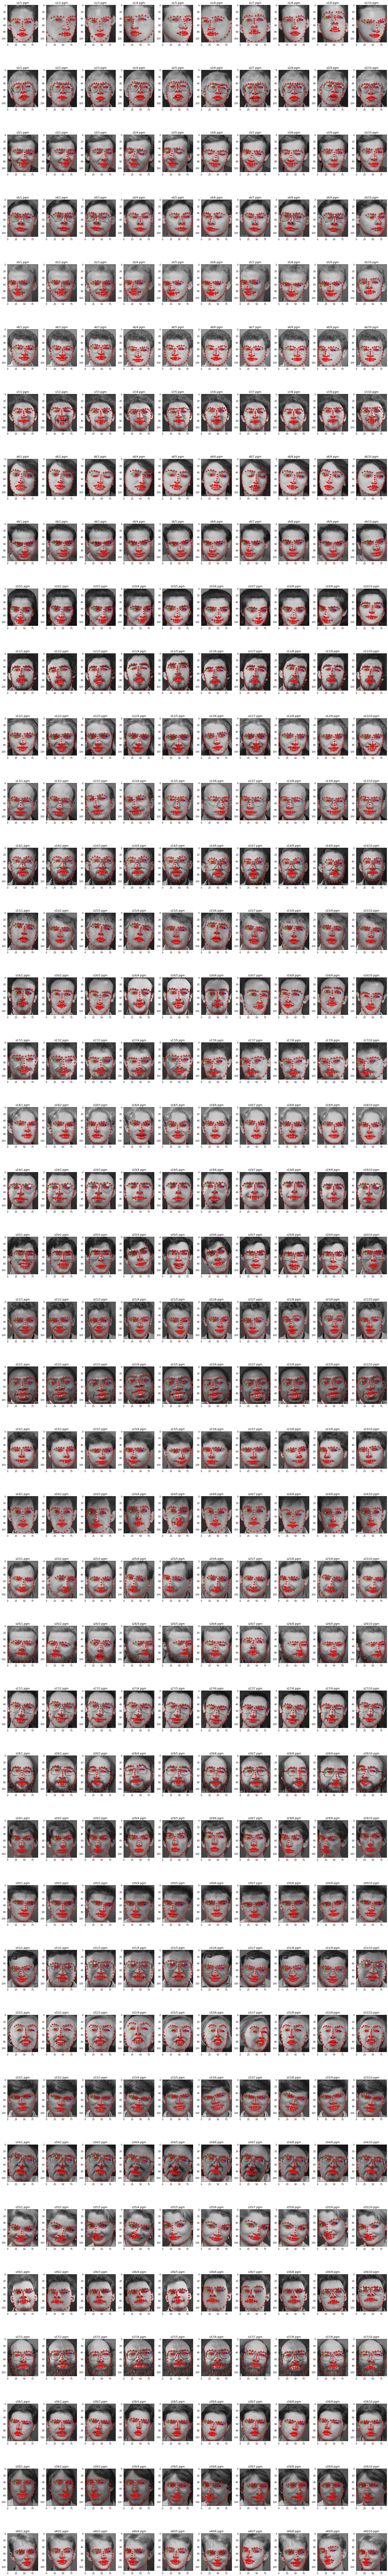

In [6]:


# Calculate figsize for plots
width, height = plt.rcParams.get('figure.figsize')
figsize = (width*4, height * 40)

with open('/content/drive/My Drive/eyes.csv', mode='w') as csv_file:
  plt.figure(figsize=figsize)
  csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  csv_writer.writerow(['Image', "left_eye_x", "left_eye_y", "right_eye_x", "right_eye_y"])
  all_files = []
  for i in os.walk(os.path.join('ORLFaceRecognition-PCA','att_faces')):
    address, dirs, files = i[0], i[1], i[2]
    person = address.split('/')[-1]
    
    for filename in fnmatch.filter(files, '*.pgm'):
      img_path = os.path.join(address,filename)
      img = cv2.imread(os.path.join(address,filename))
      all_files.append(img_path)
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      faces, scores, idx = detector.run(gray, 1, -0.6)
      for face in faces:
        csv_writer.writerow([os.path.join(person,filename), *geteyes(predictor(gray, face), 36, 45)])
        landmarks = predictor(gray, face)
        for landmark in landmarks.parts():
          cv2.circle(img, (landmark.x, landmark.y) , 2, (255, 0, 0), -1)#red
        cv2.circle(
          img, (geteye(predictor(gray, face), 36)) , 2, (0, 255, 0), -1)#green
        cv2.circle(
          img, (geteye(predictor(gray, face), 45)) , 2, (0, 0, 255), -1)#blue
      #print(filename.split('.')[-2])
      #print(person[1:])
      plt.subplot(40, 10, int(filename.split('.')[-2])+10*(int(person[1:])-1))
      plt.imshow(img)
      plt.title(os.path.join(person,filename))
  #plt.tight_layout(rect=[0,0,1,0.97])
  plt.tight_layout()

     

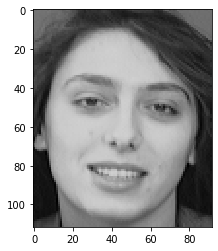

In [7]:
img = cv2.imread(all_files[0])
plt.imshow(img)

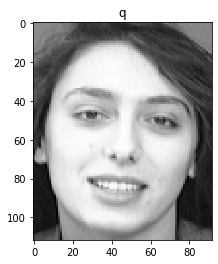

In [297]:
def vec_to_image(v,w=(height,width)):
    img=v.reshape(w[0],w[1])
    return img

def show_image(ind,data,label,size=(height,width)):
    img=vec_to_image(data[ind],size)
    plt.imshow(img, cmap='gray')
    plt.title(label)

show_image(0,X,"q")

In [0]:
rows=len(all_files)
height=img.shape[0]
width=img.shape[1]
columns=height*width

In [0]:
Y = np.zeros((rows,1))
X = np.zeros((rows, columns))
for row, file in enumerate(all_files):
  #print(row)
  img = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2GRAY)
  img = img.reshape(1,img.shape[0]*img.shape[1])
  X[row,:] = img
  Y[row] = int(file.split('/')[-2][1:])


In [0]:
def split_dataset(X, Y, train_percent = 80):
  def prereshape(*args):
    res = []
    for arg in args:
      res.append(arg.reshape(40,10,arg.shape[1]))
    return res

  def slice_dataset(*args, train_percent=8):
    res = []
    for arg in args:
      res.append(arg[:,:train_percent,:])
      res.append(arg[:,train_percent:,:])
    return res

  def postreshape(*args):
    res = []
    for arg in args:
      res.append(arg.reshape(arg.shape[0]*arg.shape[1],arg.shape[2]))
    return res  

  train_percent = int(train_percent /10)
  X,Y = prereshape(X,Y)
  X_train, X_test, Y_train, Y_test = slice_dataset(X, Y, train_percent = train_percent)
  X_train, X_test, Y_train, Y_test = postreshape(X_train, X_test, Y_train, Y_test) 
  return X_train, X_test, Y_train, Y_test

def split_dataset_shuffle(X, Y, train_percent = 80):
  train_percent = train_percent /100
  return train_test_split(
        X,
        Y,
        random_state=1,
        train_size=train_percent
    )

In [0]:
def predict_by_mse(X_train,Y_train,X_test):
  def mse(X_train, X_test):
    return (np.square(X_train - X_test)).mean(axis=1)#np.mean((X_train - X_test)**2)
  Y_pred =[]
  for i in range (0, X_test.shape[0]):
    Y_pred.append(Y_train[mse(X_train, X_test[i]).argmin()][0])
  Y_pred = np.array(Y_pred)
  Y_pred = Y_pred.reshape(Y_pred.shape[0],1)
  return Y_pred

In [0]:
def get_compare(Y_test, Y_pred):
  compare = Y_test == Y_pred
  return compare
def get_accuracy(acc):
  return acc.sum()/acc.shape[0]

In [0]:
def iterate_train_percent(X, Y, split_method, picview = False):
  print("train_percent\taccuracy")
  for train_percent in range (10, 100, 10):
    X_train, X_test, Y_train, Y_test = split_method(X, Y, train_percent = train_percent)
    Y_pred = predict_by_mse(X_train, Y_train, X_test)
    compare = get_compare(Y_test, Y_pred)
    accuracy = get_accuracy(compare)
    print("{}\t{:.3f}".format(train_percent,accuracy))
    if picview:
      width, height = plt.rcParams.get('figure.figsize')
      cheight = compare.shape[0]
      plt.figure()
      for i in range (0, cheight):
        if not compare[i,0]:
          plt.subplot(1,2,1)
          show_image(i, X_test, Y_test[i])
          plt.subplot(1,2,2)
          show_image(np.where(Y_train == Y_pred[i])[0][0], X_train, Y_pred[i])
          plt.show()
     

In [0]:
def iterate_by_split(X, Y, picview = False):
  split_methods = [split_dataset,split_dataset_shuffle]
  for split_method in split_methods:
    iterate_train_percent(X, Y, split_method = split_method, picview = picview)

In [369]:
iterate_by_split(X, Y,  picview = False)

train_percent	accuracy
10	0.642
20	0.850
30	0.882
40	0.912
50	0.925
60	0.944
70	0.958
80	0.963
90	0.925
train_percent	accuracy
10	0.458
20	0.688
30	0.746
40	0.867
50	0.920
60	0.919
70	0.950
80	0.938
90	0.975
